In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from analysis.preprocess import get_tokenized_sentences
from analysis.ngram import NgramCounter, NgramModel, calculate_avg_ll
import numpy as np
import pandas as pd
from analysis.plot_utils import plt, legend_opts, savefig
from matplotlib import cm

## Training model

In [3]:
train_counter = NgramCounter('../data/train_tokenized.txt')
dev1_counter = NgramCounter('../data/dev1_tokenized.txt')
dev2_counter = NgramCounter('../data/dev2_tokenized.txt')

In [4]:
train_model = NgramModel(train_counter)
train_model.train()

In [5]:
train_prob_matrix = train_model.evaluate('../data/train_tokenized.txt')
dev1_prob_matrix = train_model.evaluate('../data/dev1_tokenized.txt')
dev2_prob_matrix = train_model.evaluate('../data/dev2_tokenized.txt')

In [6]:
train_tokens = [token for sentence in get_tokenized_sentences('../data/train_tokenized.txt') for token in sentence]
dev1_tokens = [token for sentence in get_tokenized_sentences('../data/dev1_tokenized.txt') for token in sentence]
dev2_tokens = [token for sentence in get_tokenized_sentences('../data/dev2_tokenized.txt') for token in sentence]

In [7]:
train_prob_df = pd.DataFrame(train_prob_matrix)
dev1_prob_df = pd.DataFrame(dev1_prob_matrix)
dev2_prob_df = pd.DataFrame(dev2_prob_matrix)

train_prob_df['token'] = train_tokens
dev1_prob_df['token'] = dev1_tokens
dev2_prob_df['token'] = dev2_tokens

## Result

In [10]:
def plot_interpolate_with_uniform(ax, prob_matrix, ngram_weight, text_location, show_legend=True):
    cmap = cm.winter_r
    ngram_lengths = list(range(1, 6))
    uniform_weight = 1 - ngram_weight

    avg_lls = []
    for ngram_length in ngram_lengths:
        avg_ll = calculate_avg_ll(prob_matrix[:, [0, ngram_length]], weights=[uniform_weight, ngram_weight])
        avg_lls.append(avg_ll)
    ax.plot(ngram_lengths, avg_lls, 'o-', label=f'{ngram_weight:.2f}', color=cmap(ngram_weight))
    if show_legend:
        ax.legend(title='Fraction of\nngram model', bbox_to_anchor=(1.04, 0), loc='lower left', **legend_opts)
    if text_location == 'right':
        ax.text(5.1, avg_lls[-1], s=f'{ngram_weight:.2f}', fontsize=12, ha='left', va='center', color=cmap(ngram_weight))
    else:
        ax.text(0.9, avg_lls[-1], s=f'{ngram_weight:.2f}', fontsize=12, ha='right', va='center', color=cmap(ngram_weight))
        
    ax.set_xlim(0, 6)
    ax.set_xticks(range(1, 6))
    ax.set_yticks(np.arange(-20, 1, 5))
    ax.set_ylim(-20, 0)
    
    ax.set_xlabel('n-gram length')

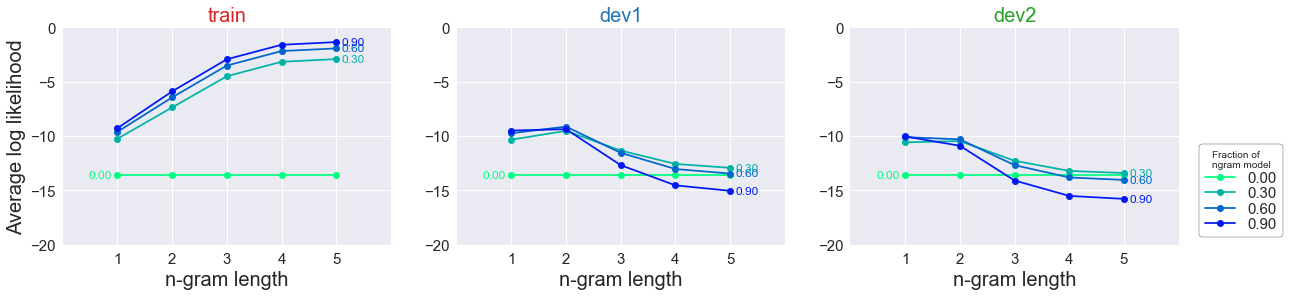

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
text_locations_by_weight = {0: 'left', 0.3: 'right', 0.6: 'right', 0.9: 'right'}

for ngram_weight, text_location in text_locations_by_weight.items():
    plot_interpolate_with_uniform(ax1, train_prob_matrix, ngram_weight=ngram_weight, text_location=text_location, show_legend=False)
    plot_interpolate_with_uniform(ax2, dev1_prob_matrix, ngram_weight=ngram_weight, text_location=text_location, show_legend=False)
    plot_interpolate_with_uniform(ax3, dev2_prob_matrix, ngram_weight=ngram_weight, text_location=text_location)
    

ax1.set_ylabel('Average log likelihood') 
ax1.set_title('train', color='tab:red')
ax2.set_title('dev1', color='tab:blue')
ax3.set_title('dev2', color='tab:green')
savefig(fig, 'ngram_result.png')

### Plot conditional distribution of bigram starting with 'the'

In [12]:
train_thegrams = {ngram[1]: count for ngram, count in train_counter.counts.items() if len(ngram)==2 and ngram[0]=='the'}
dev1_thegrams = {ngram[1]: count for ngram, count in dev1_counter.counts.items() if len(ngram)==2 and ngram[0]=='the'}
dev2_thegrams = {ngram[1]: count for ngram, count in dev2_counter.counts.items() if len(ngram)==2 and ngram[0]=='the'}

In [13]:
sorted_train_thegrams = []
train_thegrams_percents = []
dev1_thegrams_percents = []
dev2_thegrams_percents = []

train_the_count = train_counter.counts[('the',)]
dev1_the_count = dev1_counter.counts[('the',)]
dev2_the_count = dev2_counter.counts[('the',)]
for thegram, thegram_count in sorted(train_thegrams.items(), key=lambda item: item[1], reverse=True):
    sorted_train_thegrams.append(thegram)
    train_thegrams_percents.append(thegram_count*100/train_the_count)
    dev1_thegrams_percents.append(dev1_thegrams.get(thegram, 0)*100/dev1_the_count)
    dev2_thegrams_percents.append(dev2_thegrams.get(thegram, 0)*100/dev2_the_count)

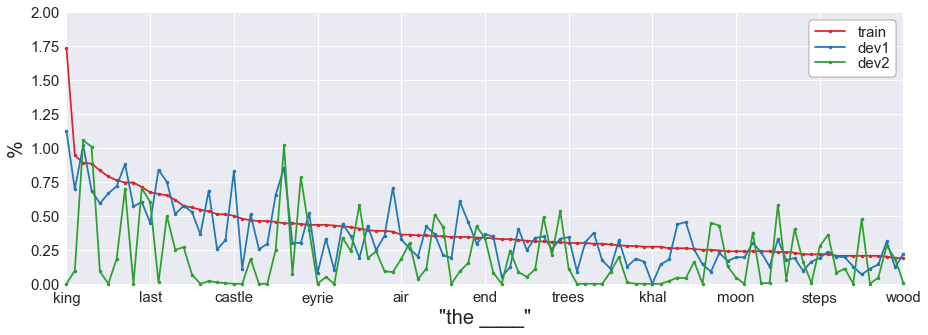

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
xlim = 101
ax.plot(np.array(train_thegrams_percents[:xlim]), '.-', label='train', color='tab:red', clip_on=False)
ax.plot(np.array(dev1_thegrams_percents[:xlim]), '.-', label='dev1', color='tab:blue', clip_on=False)
ax.plot(np.array(dev2_thegrams_percents[:xlim]), '.-', label='dev2', color='tab:green', clip_on=False)


xticks = range(0, xlim+1, 10)
xticklabels = np.array(sorted_train_thegrams)[xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.legend(**legend_opts)
ax.set_xlim(0, xlim-1)
ax.set_ylim(0, 2)
ax.set_xlabel('"the ____"')
ax.set_ylabel('%')
savefig(fig, 'thegram.png')

### Plot average log likelihood vs fraction of unknown n-grams

In [15]:
ngram_weight = 0.9
uniform_weight = 1 - ngram_weight
dev1_n_tokens = len(dev1_prob_matrix)
dev2_n_tokens = len(dev2_prob_matrix)

dev1_avg_lls = []
dev1_new_ngram_percents = []
dev2_avg_lls = []
dev2_new_ngram_percents = []

for n in range(1, 6):
    dev1_new_ngram_percents.append((dev1_prob_matrix[:, n]==0).sum()*100 / dev1_n_tokens)
    dev2_new_ngram_percents.append((dev2_prob_matrix[:, n]==0).sum()*100 / dev2_n_tokens)
    dev1_avg_lls.append(calculate_avg_ll(dev1_prob_matrix[:, [0, n]], weights=[uniform_weight, ngram_weight]))
    dev2_avg_lls.append(calculate_avg_ll(dev2_prob_matrix[:, [0, n]], weights=[uniform_weight, ngram_weight]))

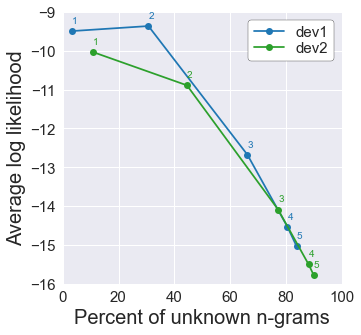

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(dev1_new_ngram_percents, dev1_avg_lls, 'o-', color='tab:blue', clip_on=False, label='dev1')
ax.plot(dev2_new_ngram_percents, dev2_avg_lls, 'o-', color='tab:green', clip_on=False, label='dev2')

for n in range(1, 6):
    ax.text(dev1_new_ngram_percents[n-1], dev1_avg_lls[n-1]+0.2, s=n, color='tab:blue')
    ax.text(dev2_new_ngram_percents[n-1], dev2_avg_lls[n-1]+0.2, s=n, color='tab:green')

ax.set_xlim(0, 100)
ax.set_ylim(-16, -9)
ax.set_xlabel('Percent of unknown n-grams')
ax.set_ylabel('Average log likelihood')

ax.legend(**legend_opts)

savefig(fig, 'unknown_ngrams_vs_ll.png')

## Save probability matrices for dev1 and dev2 for part 3

In [17]:
np.save('../data/train_prob_matrix.npy', train_prob_matrix)
np.save('../data/dev1_prob_matrix.npy', dev1_prob_matrix)
np.save('../data/dev2_prob_matrix.npy', dev2_prob_matrix)